In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)


/Users/elenag/Desktop/PlotterLEE/


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights() # the default option is FHC, RHC needs different arguments

In [5]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 04232021


In [6]:
SHRCALIBFACTOR = 1.00

In [7]:
# USING BDT?
USEBDT = True

In [8]:
# Doing Run3?
ISRUN3 = False

In [9]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [10]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [11]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)



In [12]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [13]:
UBooNEinNuMI_Pos = np.array([5502, 7259, 67270])
print("Distance from NuMI target", (np.linalg.norm(UBooNEinNuMI_Pos))/100., "cm")

Distance from NuMI target 678.8385658608386 cm


In [14]:
tree = "NeutrinoSelectionFilter"

# original
#BNB  = 'neutrinoselection_filt_run1_beamon_beamgood_all' +ls.APPEND
#EXT  = 'neutrinoselection_filt_run1_beamoff_all'         +ls.APPEND
#NU   = 'newTune/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#NUE  = 'newTune/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#DRT  = 'neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
# old tune
#NUO  = 'neutrinoselection_filt_run1_overlay'            +ls.APPEND
#NUEO = 'neutrinoselection_filt_run1_overlay_intrinsic'  +ls.APPEND
#mcO   = uproot.open(ls.ntuple_path+NUO +".root")[ls.fold][tree]
#nueO  = uproot.open(ls.ntuple_path+NUEO+".root")[ls.fold][tree]


#new
BNB  = 'nuePreselection_NuMI/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = 'nuePreselection_NuMI/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = 'nuePreselection_NuMI/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
NUE  = 'fullDataSets/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
DRT  = 'nuePreselection_NuMI/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND


mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]


uproot_v = [mc,nue,ext,data,dirt] 

variables = ["run", "sub", "evt", "nu_pdg","shr_tkfit_nhits_Y", "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_dedx_Y", 
             "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", 
             "shr_tkfit_2cm_nhits_Y", "shr_tkfit_2cm_nhits_U", "shr_tkfit_2cm_nhits_V", 
             "shr_tkfit_2cm_dedx_Y", "shr_tkfit_2cm_dedx_U", "shr_tkfit_2cm_dedx_V",             
             "shr_energy_tot_cali", "trk_energy_tot", "shr_energy", "shr_theta", "trk_theta_v", "trk_phi_v", 
             "trk_score_v", "trk_llr_pid_score_v", "topological_score","trk_energy_proton_v", "trk_calo_energy_y_v", "trk_id", 
             "n_tracks_contained", "shrsubclusters0", "shrsubclusters1", "shrsubclusters2", 
             "shr_tkfit_npointsvalid", "shr_tkfit_npoints", "secondshower_Y_dir", "shrclusdir2", "trk_theta", 
             "trk_sce_start_x_v", "trk_sce_start_y_v", "trk_sce_start_z_v", 
             "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_phi", "trk_theta",
             "shrmoliereavg", "secondshower_Y_dot", "true_e_visible","shrPCALen",
             "pfnhits", "pfnunhits", "flash_time", "category", "shr_score", "tksh_distance","interaction", "tksh_angle",
             "trkshrhitdist2", "hits_ratio", "secondshower_Y_nhit", "secondshower_Y_vtxdist", "CosmicIPAll3D", 
             "CosmicDirAll3D", "nslice", "selected", "_opfilter_pe_beam", "_opfilter_pe_veto", "n_showers_contained", 
             "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", 
             "pt", "shr_phi", "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
             "shr_tkfit_gap10_dedx_Y", "shr_tkfit_gap10_dedx_U", "shr_tkfit_gap10_dedx_V",
             "slnunhits","slnhits","pi0_e","ccnc","shr_pz","shr_py","shr_px","npi0"]

varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz","isVtxInFiducial","elec_e","elec_px","elec_py","elec_pz","proton_e"]
'''
variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "shr_pfp_id_v", "category", "flash_time",
    "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
    "shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y",
    "shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y",
    "topological_score",
    #"shr_energy_tot", 
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    "crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy2",
    #"run","sub","evt",
    "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score",
    #"trk_pfp_id",
    "shrmoliereavg","shrmoliererms",
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
    "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
    "trkshrhitdist2", # "trkshrhitdist0","trkshrhitdist1", distance between track and shower in 2D
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trk_llr_pid_score_v", # trk-PID score
    "trk_energy_proton_v", # track energy under proton hyp
    "trk_calo_energy_y_v", # track calo energy
    #"pi0_energy2_Y", # pi0 tagger variables
    "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", 
    "run", "sub", "evt", 
    "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z","contained_fraction",
    "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","secondshower_Y_dir","shrclusdir2",
    "shr_tkfit_nhits_Y","shr_tkfit_nhits_U","shr_tkfit_nhits_V",
    "shr_tkfit_2cm_nhits_Y","shr_tkfit_2cm_nhits_U","shr_tkfit_2cm_nhits_V",
    "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
    "pfnhits","pfnunhits",
    "trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
    "trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v","shr_id", 
    "pi0_radlen1","pi0_radlen2","pi0_dot1","pi0_dot2","pi0_energy1_Y","pi0_energy2_Y",
    "pi0_dedx1_fit_Y","pi0_dedx2_fit_Y","pi0_shrscore1","pi0_shrscore2","pi0_gammadot",
    "pi0_dedx1_fit_V","pi0_dedx2_fit_V","pi0_dedx1_fit_U","pi0_dedx2_fit_U",
    "pi0_mass_Y","pi0_mass_V","pi0_mass_U",
    "pi0_dir2_x","pi0_dir2_y","pi0_dir2_z","pi0_dir1_x","pi0_dir1_y","pi0_dir1_z",
    "pi0truth_gamma1_etot","pi0truth_gamma2_etot","pi0truth_gammadot","pi0truth_gamma_parent",
    "trk_theta_v","trk_phi_v"
]
'''

#make the list unique
variables = list(set(variables))
print(variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi","nu_decay_mode"]


    
dirt = dirt.pandas.df(variables+varMC + WEIGHTS + SYSTEMATICS, flatten=False)
nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
mc   = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext  = ext.pandas.df(variables, flatten=False)



['shrsubclusters1', 'reco_nu_vtx_sce_x', 'npi0', 'category', 'reco_nu_vtx_sce_z', 'secondshower_Y_nhit', 'secondshower_Y_vtxdist', 'shr_tkfit_dedx_U', 'shrPCALen', 'secondshower_Y_dot', 'trk_energy_proton_v', 'trk_calo_energy_y_v', 'nu_pdg', 'shr_tkfit_2cm_nhits_Y', 'trk_theta', 'shr_py', 'shr_tkfit_npoints', 'shr_tkfit_gap10_dedx_Y', 'tksh_angle', 'shr_px', '_opfilter_pe_veto', 'reco_nu_vtx_sce_y', 'trk_sce_start_z_v', 'shr_tkfit_2cm_dedx_Y', 'shr_tkfit_2cm_nhits_U', 'secondshower_Y_dir', 'shr_pz', 'shr_tkfit_gap10_nhits_Y', 'shr_tkfit_2cm_dedx_U', 'slnhits', 'shrsubclusters0', 'pt', 'trk_sce_start_y_v', 'sub', 'trk_energy_tot', 'hits_ratio', 'flash_time', 'shr_tkfit_nhits_Y', 'trk_sce_start_x_v', 'shrclusdir2', 'shr_energy_tot_cali', 'shr_tkfit_gap10_dedx_V', 'trk_sce_end_z_v', 'shr_phi', 'trk_phi_v', 'CosmicIPAll3D', 'run', 'shr_tkfit_nhits_V', 'shr_energy', 'nslice', 'topological_score', 'trk_score_v', 'trk_theta_v', 'shr_tkfit_gap10_nhits_V', 'ccnc', 'shr_tkfit_2cm_nhits_V', 'evt'

In [15]:
print(max(data['run']), min(data['run']))

6698 4952


In [16]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [17]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.



In [18]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']


In [19]:

df_v = [mc,nue]
scaleFlat = 1
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        


In [20]:

# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!
import time
s = time.time()
df_v = [mc,nue,ext,data,dirt]
print(data.shape)
print(ext.shape)
print(nue.shape)
print(mc.shape)
puppa1 = 'trk_score_v'
#print ('trk_llr_pid_score_v' in nue.columns.to_list())


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel
    
    #df['n_protons_tot'] = proton_mask.sum()

    print(trk_score_v.shape, len(trk_llr_pid_v))
#    print(len(c), len(trk_id), len(trk_llr_pid_v))
#    for pidv,puppa,tid,cid in zip(trk_llr_pid_v,trk_score_puppa_v,trk_id,c):
#        if len(pidv) > 0:
#            print(len(pidv),len(puppa), pidv,puppa,tid,cid )
#    nnnnnnnPupppppppaaa = 0
#    print(type(trk_llr_pid_v), trk_llr_pid_v.shape)
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    #df['n_proton_cand']   = puppa_proton
    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel


    #print(  df['N_recoShowers'])

for i,df in enumerate(df_v):
    df['shr_numi_Angle']        = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle']     = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)
    df['shr_Angle_Numi_target'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['proton_Angle_Numi_target'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['protontheta'],x['protonphi']) , axis=1)
    df['theta1PlusTheta2_Numi_target'] = df['shr_Angle_Numi_target'] + df['proton_Angle_Numi_target']
    df['cosShr_Angle_Numi_target'] = np.cos(df['shr_Angle_Numi_target'])
    df['cosProton_Angle_Numi_target'] = np.cos(df['proton_Angle_Numi_target'])

s2 = time.time()
print (s-s2)

(7502, 86)
(6087, 86)
(127551, 139)
(46815, 139)
(46815,) 46815
(127551,) 127551
(6087,) 6087
(7502,) 7502
(4634,) 4634


/Users/elenag/miniconda3/envs/peleeNB/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


-142.90064787864685


In [21]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    #print("p",p)
    #print(px)
    #print(py)
    #print(pz)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    shr_px_v            = up.array('shr_px')
    shr_py_v            = up.array('shr_py')
    shr_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    #print(proton_mask_v)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, shr_px_v,shr_py_v,shr_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)
        '''
        print("tempMom",tempMom)
        sillyCount +=1
        if sillyCount > 10:
            break
        '''
    print(len(listPx), df.shape)
    df['shr_p']       = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['dir_shr_px']  = df['shr_px']/df['shr_p']
    df['dir_shr_py']  = df['shr_py']/df['shr_p']
    df['dir_shr_pz']  = df['shr_pz']/df['shr_p']
    
    df['nu_reco_px']  = listPx
    df['nu_reco_py']  = listPy
    df['nu_reco_pz']  = listPz
    df['BNBP']     = np.sqrt(df['nu_reco_px']*df['nu_reco_px'] + df['nu_reco_py']*df['nu_reco_py'] + df['nu_reco_pz']*df['nu_reco_pz'])
    df['BNBPt']    = np.sqrt(df['nu_reco_px']*df['nu_reco_px'] + df['nu_reco_py']*df['nu_reco_py'])
    df['BNBTheta'] = np.arccos(df['nu_reco_pz']/df['BNBP'] )
    df['BNBPhi']   = np.arctan2(df['nu_reco_py'],df['nu_reco_px'])
    df['nu_Angle_Numi_Theta'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['BNBTheta'],x['BNBPhi']) , axis=1)
    df['cosNu_Angle_Numi_Theta'] = np.cos(df['nu_Angle_Numi_Theta'])
    df['NuMIPt'] = df['BNBP'] * (np.sin(df['nu_Angle_Numi_Theta']))
    df['checkPt']  = df['BNBPt'] - df['pt']



46815 (46815, 160)
127551 (127551, 160)
6087 (6087, 107)
7502 (7502, 107)


/Users/elenag/miniconda3/envs/peleeNB/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  


4634 (4634, 141)


In [22]:
for i,df in enumerate(df_v):
    up = uproot_v[i]
    #trk_score_v = up.array('trk_score_v')
    trk_sce_start_x_v = up.array('trk_sce_start_x_v')
    trk_sce_start_y_v = up.array('trk_sce_start_y_v')
    trk_sce_start_z_v = up.array('trk_sce_start_z_v')
    trk_sce_end_x_v = up.array('trk_sce_end_x_v')
    trk_sce_end_y_v = up.array('trk_sce_end_y_v')
    trk_sce_end_z_v = up.array('trk_sce_end_z_v')
    shr_id = up.array('shr_id')-1 # I think we need this -1 to get the right result
    #trk_score_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_score_v,shr_id)])
    trk_sce_start_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_x_v,shr_id)])
    trk_sce_start_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_y_v,shr_id)])
    trk_sce_start_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_z_v,shr_id)])
    trk_sce_end_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_x_v,shr_id)])
    trk_sce_end_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_y_v,shr_id)])
    trk_sce_end_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_z_v,shr_id)])
    #df['shr_score_check'] = trk_score_v_sel
    df['shr_trk_sce_start_x'] = trk_sce_start_x_v_sel
    df['shr_trk_sce_start_y'] = trk_sce_start_y_v_sel
    df['shr_trk_sce_start_z'] = trk_sce_start_z_v_sel
    df['shr_trk_sce_end_x'] = trk_sce_end_x_v_sel
    df['shr_trk_sce_end_y'] = trk_sce_end_y_v_sel
    df['shr_trk_sce_end_z'] = trk_sce_end_z_v_sel   

In [23]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    #
    # secondshower_U/V/Y_dot need to be set to 9999. to match data ntuples produced with v08_00_00_43 or later;
    # the patch below is valid only to match data ntuples produced with v08_00_00_42.
    #
    #df.loc[df['secondshower_U_dot'].isna(),'secondshower_U_dot'] = 0.0 #for 0p please uncomment
    #df.loc[df['secondshower_V_dot'].isna(),'secondshower_V_dot'] = 0.0 #for 0p please uncomment
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [24]:
#
for i,df in enumerate(df_v):
    up = uproot_v[i]
    df["slclnhits"] = up.array("pfnhits").sum()
    df["slclnunhits"] = up.array("pfnunhits").sum()
#

In [25]:
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
    df['shr_tkfit_nhi'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [26]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
for i,df in enumerate(df_v):
    df["theta1PlusTheta2"] = df["shr_theta"]+df["trk_theta"]
    df["phi1MinusPhi2"] = df["shr_phi"]-df["trk_phi"]
    df["AbsPhi1MinusPhi2"] = np.abs(df["shr_phi"]-df["trk_phi"])
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])

# test calibrating dedx on Y plane
#data["shr_tkfit_gap10_dedx_Y"] = data["shr_tkfit_gap10_dedx_Y"]*1.03
#ext["shr_tkfit_gap10_dedx_Y"] = ext["shr_tkfit_gap10_dedx_Y"]*1.03
#data["shr_tkfit_2cm_dedx_Y"] = data["shr_tkfit_2cm_dedx_Y"]*1.03
#ext["shr_tkfit_2cm_dedx_Y"] = ext["shr_tkfit_2cm_dedx_Y"]*1.03
#data["shr_tkfit_dedx_Y"] = data["shr_tkfit_dedx_Y"]*1.03
#ext["shr_tkfit_dedx_Y"] = ext["shr_tkfit_dedx_Y"]*1.03

In [27]:
# add back the cosmic category, for background only
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [28]:
#reset timing
df_v = [mc,nue,dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

df_v = [ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359

In [29]:
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11


In [30]:
# variables to be trained on
TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_dedx_max","trkfit","trkpid",
            "subcluster","shrmoliereavg",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            "CosmicIPAll3D","CosmicDirAll3D"]

In [31]:
LABELS = ['pi0','nonpi0']

if (USEBDT == True):
    for label, bkg_query in zip(LABELS, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_0304_extnumi.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            #print((ls.pickle_path+'booster_%s_0304_extnumi.model' % label), booster.best_iteration)
            #booster.save_model( (ls.pickle_path+'booster_%s_0304_extnumi.model' % label) )
            #mcO[label+"_score"] = booster.predict(
            #    xgb.DMatrix(mc[TRAINVAR]),
            #    ntree_limit=booster.best_iteration)
            #nueO[label+"_score"] = booster.predict(
            #    xgb.DMatrix(nue[TRAINVAR]),
            #    ntree_limit=booster.best_iteration)
            mc[label+"_score"] = booster.predict(
                xgb.DMatrix(mc[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nue[label+"_score"] = booster.predict(
                xgb.DMatrix(nue[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ext[label+"_score"] = booster.predict(
                xgb.DMatrix(ext[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            data[label+"_score"] = booster.predict(
                xgb.DMatrix(data[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            dirt[label+"_score"] = booster.predict(
                xgb.DMatrix(dirt[TRAINVAR]),
                ntree_limit=booster.best_iteration)


In [32]:
# Some quick clean up since some strange events get in there

#mc   = mc.query('nu_e > 0.')
#nue  = nue.query('nu_e > 0.')
#dirt = dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam
dfmc_v = [mc,nue,dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

In [33]:
'''
def fetchThatWeight (weightVector,wCV, wIntex):
    return wCV*(weightVector[wIntex])
'''

'\ndef fetchThatWeight (weightVector,wCV, wIntex):\n    return wCV*(weightVector[wIntex])\n'

In [34]:
'''
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df['var1'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],0) , axis=1)
    df['var2'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],1) , axis=1)
    df['var3'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],2) , axis=1)
    df['var4'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],3) , axis=1)
    df['var5'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],4) , axis=1)
    df['var6'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],5) , axis=1)
    df['var7'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],6) , axis=1)
    df['var8'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],7) , axis=1)
    df['var9'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],8) , axis=1)
    df['var10'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],9) , axis=1)
    df['var11'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],10) , axis=1)
    df['var12'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],11) , axis=1)
    df['var13'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],12) , axis=1)
    df['var14'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],13) , axis=1)
    df['var15'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],14) , axis=1)
    df['var16'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],15) , axis=1)
    df['var17'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],16) , axis=1)
    df['var18'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],17) , axis=1)
    df['var19'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],18) , axis=1)
    df['var20'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],19) , axis=1)
'''

"\ndf_v = [mc,nue,dirt]\n#removeGenieTune = False\nfor i,df in enumerate(df_v):\n    df['var1'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],0) , axis=1)\n    df['var2'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],1) , axis=1)\n    df['var3'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],2) , axis=1)\n    df['var4'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],3) , axis=1)\n    df['var5'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],4) , axis=1)\n    df['var6'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],5) , axis=1)\n    df['var7'] = df.apply( lambda x: fetchThatWeight(x['weightsNuMIGeo'],x['weightSplineTimesTuneTimesPPFX'],6) , axis=1)\n    df['var8'] = df.apply( lambda x: fetchThatWeight(x['we

In [35]:
df_v = [mc,nue,ext,data,dirt]

for i,df in enumerate(df_v):
    df['cosShrTheta'] = np.cos(df['shr_theta'])
    df['cosTrkTheta'] = np.cos(df['trk_theta'])

# Plotting part

In [36]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py'>

In [37]:
'''
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.


nue = nue.query("(abs(nu_pdg) == 12 & ccnc == 0)")
samples = {
    "mc": mc, 
    "nue": nue,
#    "dirt": dirt,
    "data": data,
    "ext": ext
}

scaling = 1
#scaling = 0.789
pot =  2e+20 #partial file: 8.885e+19
mcratio   = pot/5.46001e+19#norm on wiki: 1.18488e+21; current norm on my plotter:  2.18488e+21
nueratio  = pot/5.46001e+19 #norm on wiki: 1.85664e+22
dirtratio = pot/5.46001e+19 # right number: 1.42143e+21
extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.35

weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
#            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}
print (ext.shape[0])
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)
'''

'\nscaling = 1\n\nSPLIT = 1.0\nif (USEBDT == True):\n    SPLIT = 2.\n\n\nnue = nue.query("(abs(nu_pdg) == 12 & ccnc == 0)")\nsamples = {\n    "mc": mc, \n    "nue": nue,\n#    "dirt": dirt,\n    "data": data,\n    "ext": ext\n}\n\nscaling = 1\n#scaling = 0.789\npot =  2e+20 #partial file: 8.885e+19\nmcratio   = pot/5.46001e+19#norm on wiki: 1.18488e+21; current norm on my plotter:  2.18488e+21\nnueratio  = pot/5.46001e+19 #norm on wiki: 1.85664e+22\ndirtratio = pot/5.46001e+19 # right number: 1.42143e+21\nextratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99\nSPLIT = 1.0\nscalingEXT = 0.98\nscalingDRT = 0.35\n\nweights = { #full sample mc = 0.38\n            "mc"  : mcratio  * SPLIT * scaling,   \n            "nue" : nueratio * SPLIT * scaling,  \n            "ext" : extratio * SPLIT * scalingEXT, #set0   \n#            "dirt": dirtratio* SPLIT * scalingDRT, #set0   \n}\nprint (ext.shape[0])\nmy_plotter = plotter.Plotter(samples, weights, pot=pot)\nprint(weights)\n'

In [38]:
# muon selection
QUERY = 'nslice == 1'
#if ISRUN3: QUERY += ' and ((crtveto!=1) or (crthitpe < 100)) and (_closestNuCosmicDist > 20.)'
#QUERY += ' and trk_len > 20'
#QUERY += ' and topological_score > 0.06'
#QUERY += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251'
#QUERY += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110'
#QUERY += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986'
#QUERY += ' and trkpid > 0.5'
#QUERY += ' and (trkthetacos < 0.853 or trkthetacos > 0.8531)'
#QUERY += ' and bkpdg == 2212 and (trkcompl < 0.5 or trkpur < 0.5)'

print (QUERY)

nslice == 1


In [39]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

In [40]:
# 1eNp preselection
NPPRESQ = PRESQ
NPPRESQ += ' and n_tracks_contained > 0'

In [41]:
# very loose box cuts
NPVLCUTQ = NPPRESQ
NPVLCUTQ += ' and CosmicIPAll3D > 10.'
NPVLCUTQ += ' and trkpid < 0.25'
NPVLCUTQ += ' and hits_ratio > 0.5'
NPVLCUTQ += ' and trkfit < 0.90'
NPVLCUTQ += ' and n_showers_contained == 1'
NPVLCUTQ += ' and tksh_distance < 10.0'
NPVLCUTQ += ' and tksh_angle > -0.9'

In [42]:
# loose box cuts
NPLCUTQ = NPVLCUTQ
NPLCUTQ += ' and CosmicIPAll3D > 10.'
NPLCUTQ += ' and trkpid < 0.02'
NPLCUTQ += ' and hits_ratio > 0.50'
NPLCUTQ += ' and shrmoliereavg < 9'
NPLCUTQ += ' and subcluster > 4'
NPLCUTQ += ' and trkfit < 0.65'
NPLCUTQ += ' and n_showers_contained == 1'
NPLCUTQ += ' and tksh_distance < 6.0'
NPLCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQ += ' and secondshower_Y_nhit < 50'
NPLCUTQ += ' and tksh_angle > -0.9'

In [43]:
# BDT cuts
# 0304 extnumi, pi0 and nonpi0
BDTCQ = NPPRESQ
BDTCQ += ' and pi0_score > 0.67 and nonpi0_score > 0.70'

In [44]:
myPre = "nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0"

In [45]:
# Define actual selection
# QUERY = NPTCUTQ #NPTCUTQ
#QUERY = NPPRESQ
#QUERY = NPLCUTQ #NPTCUTQ NPLCUTQ
#QUERY = NPPRESQ 
QUERY = NPLCUTQ +" and "+ BDTCQ #PI0SEL#NUMUOnTheFly + ' and n_showers_contained == 1'  #PI0SEL#NPLCUTQ2 #NPLCUTQ #NPPRESQ#'nslice ==1 ' #NPPRESQ #PRESQ
# in case you do not want to look at the data
#QUERY += ' and bnbdata==0'
# in case you want to apply the CRT veto
#if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'

In [46]:
NN = NPVLCUTQ #NPLCUTQ #'nslice == 1 and topological_score > 0.06 '
#NN += ' and n_tracks_contained == 2 ' #and N_recoMuons == 0'
NN += ' and N_recoProtons == 2 ' #and N_recoMuons == 0'
#NN += ' and n_showers_contained == 1'


In [47]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1
    df['true_pz_visible'] = np.sqrt(df['true_p_visible']*df['true_p_visible'] - df['true_pt_visible']*df['true_pt_visible'])
    df['el_thetaXZ'] = np.arctan(df['elec_px']/df['elec_pz'])
    df['el_thetaYZ'] = np.arctan(df['elec_py']/df['elec_pz'])


/Users/elenag/miniconda3/envs/peleeNB/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
#s = time.time()
#df_v = [mc,nue,dirt]
##removeGenieTune = False
#for i,df in enumerate(df_v):
#    #print(df.shape[0])
#    for ievt in range(df.shape[0]):
#        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | (df['weightsGenie'].iloc[ievt] == np.inf))
#        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

#s2 = time.time()
#print (s-s2)
df_v = [mc,nue]
for i,df in enumerate(df_v):
    #df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    #df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    #df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1
    df['flux'] = np.zeros_like(df['nslice'])
    df.loc[ (((df['nu_pdg'] == 12) | (df['nu_pdg'] == -12)) & (df['nu_decay_mode'] < 11)) , 'flux'] = 10
    df.loc[ (((df['nu_pdg'] == 12) | (df['nu_pdg'] == -12)) & (df['nu_decay_mode'] > 10)) , 'flux'] = 1
    df.loc[ (((df['nu_pdg'] == 14) | (df['nu_pdg'] == -14)) & (df['nu_decay_mode'] < 11)) , 'flux'] = 10
    df.loc[ (((df['nu_pdg'] == 14) | (df['nu_pdg'] == -14)) & (df['nu_decay_mode'] > 10)) , 'flux'] = 1

In [49]:
import plotter
import importlib
importlib.reload(plotter)
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.

#nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
# 254.8 & true_nu_vtx_x > -1.55 )")
nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
nue   = nue.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
 254.8 & true_nu_vtx_x > -1.55)")
samples = {
    "mc": mc,
    "nue": nue, #nueMC, #nue,
    "data": data,
    #"dirt": dirt,
    "ext": ext
}

'''
scaling = 1
pot =  2e+20 #partial file: 8.885e+19
mcratio   = pot/2.32135e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
nueratio  = pot/2.59311e+22 #2.59311e+22 #norm for intrinsic = 2.59311e+22
#nueratio  = pot/2.59311e+22  ##norm for intrinsic = 2.59311e+22
dirtratio = pot/1.42143e+21
extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
'''

SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.35

scaling   = 1
pot       =  2e+20             
mcratio   = pot/2.33652e+21
nueratio  = pot/2.37838e+22    
dirtratio = pot/1.42143e+21
extratio  = 5268051.0/9199232.74
mcratio = 0

weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,      
            "ext" : extratio * SPLIT * scalingEXT, #set0   
            #"dirt": dirtratio* SPLIT * scalingDRT, #set0   
}
print (ext.shape[0])
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

6087
{'mc': 0.0, 'nue': 0.008409085175623745, 'ext': 0.5612087579382191}


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:240: UserWarning: Missing dirt sample
  warnings.warn("Missing dirt sample")


nu_pdg==12 and nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and CosmicIPAll3D > 10. and trkpid < 0.25 and hits_ratio > 0.5 and trkfit < 0.90 and n_showers_contained == 1 and tksh_distance < 10.0 and tksh_angle > -0.9 and CosmicIPAll3D > 10. and trkpid < 0.02 and hits_ratio > 0.50 and shrmoliereavg < 9 and subcluster > 4 and trkfit < 0.65 and n_showers_contained == 1 and tksh_distance < 6.0 and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5) and secondshower_Y_nhit < 50 and tksh_angle > -0.9 and nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and pi0_score > 0.67 and nonpi0_score > 0.70 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:458: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


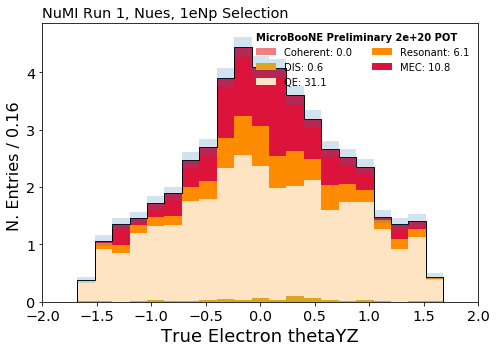

In [64]:
import matplotlib.pyplot as plt
import matplotlib
sysBool = False
#+ " and run <= 6747" 


ACCEPTANCE   = 'and isVtxInFiducial == 1 and truthFiducial == 1 and ccnc>=0 and npi0==0 and npion==0'
QUERY += ACCEPTANCE 
QUERY = "nu_pdg==12" +" and "+NPLCUTQ +" and "+ BDTCQ 
#QUERY = NPLCUTQ +" and "+ BDTCQ  + "and reco_e > 0.65 and reco_e < 0.85"




VARIABLE, BINS, RANGE, XTIT = 'true_p_visible', 40, (0.,16.0), r"True Momentum [GeV/c]"
VARIABLE, BINS, RANGE, XTIT = 'true_pt_visible', 20, (0.,2.0), r"True Momentum Proj on r [GeV/c]"
VARIABLE, BINS, RANGE, XTIT = 'true_pz_visible', 40, (0.,10.0), r"True Momentum Proj on Z [GeV/c]"

VARIABLE, BINS, RANGE, XTIT = 'true_nu_pz', 40, (0.,10.0), r"True Momentum Proj on Z [GeV/c]"
VARIABLE, BINS, RANGE, XTIT = 'true_nu_px', 40, (0.,10.0), r"True Momentum Proj on X [GeV/c]"
VARIABLE, BINS, RANGE, XTIT = 'true_nu_py', 40, (0.,10.0), r"True Momentum Proj on Y [GeV/c]"

VARIABLE, BINS, RANGE, XTIT = 'numi_nu_true_Angle', 20, (0.,120.0), r"Neutrino Angle off of NuMI Beamline [Deg]"
VARIABLE, BINS, RANGE, XTIT = 'nu_e', 25, (0.,6.0), r"True  Nue Energy [GeV]"

VARIABLE, BINS, RANGE, XTIT = 'el_thetaXZ' , 25, (-2.,2.0), r"True Electron thetaXZ"
VARIABLE, BINS, RANGE, XTIT = 'el_thetaYZ' , 25, (-2.,2.0), r"True Electron thetaYZ"

kind = "event_category" 
kind = "flux"
kind = "interaction"

nutype = "Nues"


fig, ax1, ax2,e = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,
    kind=kind,
    draw_sys  = sysBool, 
    draw_geoSys = sysBool, 
    draw_data = False,#True,
    genieweight = "weightSplineTimesTuneTimesPPFX", #"weightSplineTimesTuneTimesPPFX", 
    stacksort=3,
    ratio=False,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:5]


ax1.set_title('NuMI Run 1,  Nues, No Selection',loc='left')
ax1.set_title('NuMI Run 1, Nues, 1eNp Selection',loc='left')

#ax1.set_title('NuMI Run 1,  Nues, 1eNp, 0.85 > reco_e > 0.65',loc='left')

#ax1.set_yscale('log')
fig.tight_layout()
fig.savefig("/Users/elenag/Desktop/PlotterLEE/plots/TrueNues/JZ/"+VARIABLE+"_NuMI_run1_AllRecoE_"+kind+"_"+nutype+"_Post.pdf")


In [ ]:
#print(ax2[0],ax2[1],ax2[2])
print(type(ax2[0][1]))

content = np.zeros_like(ax2[0][1])
content = 
for a in ax2[0]:
    print(ax2[0][6])
    #content += a
print(content)

In [ ]:
x = np.arange(0, 3., 0.12)
y = [0. ,   0.  ,  0.029, 0. ,   0.056, 1.352 ,3.427 ,3.232, 2.447, 1.677, 1.007, 0.529, 0.481, 0.296, 0.427, 0.044, 0.057, 0.034 ,0.011, 0.004 ,0.056 ,0.007 ,0.016 ,0.007,0.004]
y  = y/np.sum(y)
y1 = ax2[0][6]
y1 = y1/np.sum(y1)
print(x)
plt.scatter(x,y,label="BNB") 
plt.scatter(x,y1,label="NuMI") 
plt.legend()
plt.title("0.65 < reco_e < 0.85")
plt.xlabel("True Energy")
plt.ylabel("Density")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
sysBool = False
#+ " and run <= 6747" 


ACCEPTANCE   = 'and isVtxInFiducial == 1 and truthFiducial == 1 and ccnc>=0 and npi0==0 and npion==0'
QUERY += ACCEPTANCE 
QUERY = "nu_pdg==12" # and "+NPLCUTQ +" and "+ BDTCQ 
QUERY = NPLCUTQ +" and "+ BDTCQ  + "and reco_e > 0.65 "


VARIABLE, BINS, RANGE, XTIT = 'numi_nu_true_Angle', 20, (0.,9.0), r"Neutrino Angle off of NuMI Beamline [Deg]"


VARIABLE, BINS, RANGE, XTIT = 'true_p_visible', 40, (0.,16.0), r"True Momentum [GeV/c]"
VARIABLE, BINS, RANGE, XTIT = 'true_pt_visible', 20, (0.,2.0), r"True Momentum Proj on r [GeV/c]"
VARIABLE, BINS, RANGE, XTIT = 'true_pz_visible', 40, (0.,10.0), r"True Momentum Proj on Z [GeV/c]"

VARIABLE, BINS, RANGE, XTIT = 'true_nu_pz', 40, (0.,10.0), r"True Momentum Proj on Z [GeV/c]"
VARIABLE, BINS, RANGE, XTIT = 'true_nu_px', 40, (0.,10.0), r"True Momentum Proj on X [GeV/c]"
VARIABLE, BINS, RANGE, XTIT = 'true_nu_py', 40, (0.,10.0), r"True Momentum Proj on Y [GeV/c]"
VARIABLE, BINS, RANGE, XTIT = 'nu_e', 25, (0.,6.0), r"True  Nue Energy [GeV]"

nutype = "Nues"
kind = "flux"
kind = "interaction"
kind = "event_category" 

fig, ax1, ax3,e = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,
    kind=kind,
    draw_sys  = sysBool, 
    draw_geoSys = sysBool, 
    draw_data = False,#True,
    genieweight = "weightSplineTimesTuneTimesPPFX", #"weightSplineTimesTuneTimesPPFX", 
    stacksort=3,
    ratio=False,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:5]

#ax1.set_title('NuMI Run 1, Nues, 1eNp Selection',loc='left')
ax1.set_title('NuMI Run 1, Nues, No Selection',loc='left')
ax1.set_title('NuMI Run 1,  Nues, 1eNp,  reco_e > 0.65',loc='left')

#ax1.set_yscale('log')
fig.tight_layout()
fig.savefig("/Users/elenag/Desktop/PlotterLEE/plots/TrueNues/"+VARIABLE+"_NuMI_run1_AllRecoE_"+kind+"_"+nutype+"_RecoE.pdf")


In [ ]:
x = np.arange(0, 6., 0.24)
y3 = [ 0.  ,   0.035 , 1.441 , 9.299, 12.149, 11.251 , 8.387,  6.578,  4.342,  2.805,
  2.239,  1.155 , 0.853 , 0.539 , 0.449 , 0.409 , 0.173 , 0.21  , 0.051 , 0.026,
  0.014  ,0.  ,   0. ,    0.  ,   0.  , ]
print( ax3[0][8])
y3  = y3/np.sum(y3)
y1 = ax3[0][8]
y1 = y1/np.sum(y1)
#print(x)
plt.scatter(x,y3,label="BNB") 
plt.scatter(x,y1,label="NuMI") 
plt.legend()
plt.title("reco_e > 0.65")
plt.xlabel("True Energy")
plt.ylabel("Density")


In [ ]:
18+765

In [ ]:
901.8/913